# Workshop 2: Handwritten digit classification with PyTorch
In this workshop we will learn how to train a neural network with images 
as input to classify hand-written digits
([info of the data](http://yann.lecun.com/exdb/mnist/)). The main blocks of the workshop are:

1. Get the data from PyTorch repository and visualize it.
2. Pre-process the data.
3. Design the network.
4. Train the network.
5. Evaluate the model.

# 1. Get the data from PyTorch repository and visualize it.

In [20]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [21]:
# set random seed for reproducibility
torch.manual_seed(42)

In [22]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

In [23]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [24]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FFAABD5FE80>, 5)

In [25]:
train_dataset[0][0].show()

In [26]:
sample_array = np.array(train_dataset[0][0])
print("Sample shape:", sample_array.shape)
print("Sample min value:", sample_array.min())
print("Sample max value:", sample_array.max())

Sample shape: (28, 28)
Sample min value: 0
Sample max value: 255


In [27]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [28]:
test_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FFAABF2E2F0>, 7)

In [29]:
test_dataset[0][0].show()

# 2. Pre-process the data.

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Split the test set into validation and test sets
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [31]:
images, labels = next(iter(train_loader))
print("Sample shape:", images.shape)
print("Sample min value:", images.min())
print("Sample max value:", images.max())

Sample shape: torch.Size([64, 1, 28, 28])
Sample min value: tensor(0.)
Sample max value: tensor(1.)


In [32]:
# Import dependence for visualization of images
plt.rcParams['figure.figsize'] = (10,10)  # Configure figure size for 
                                          # appropriate visualization

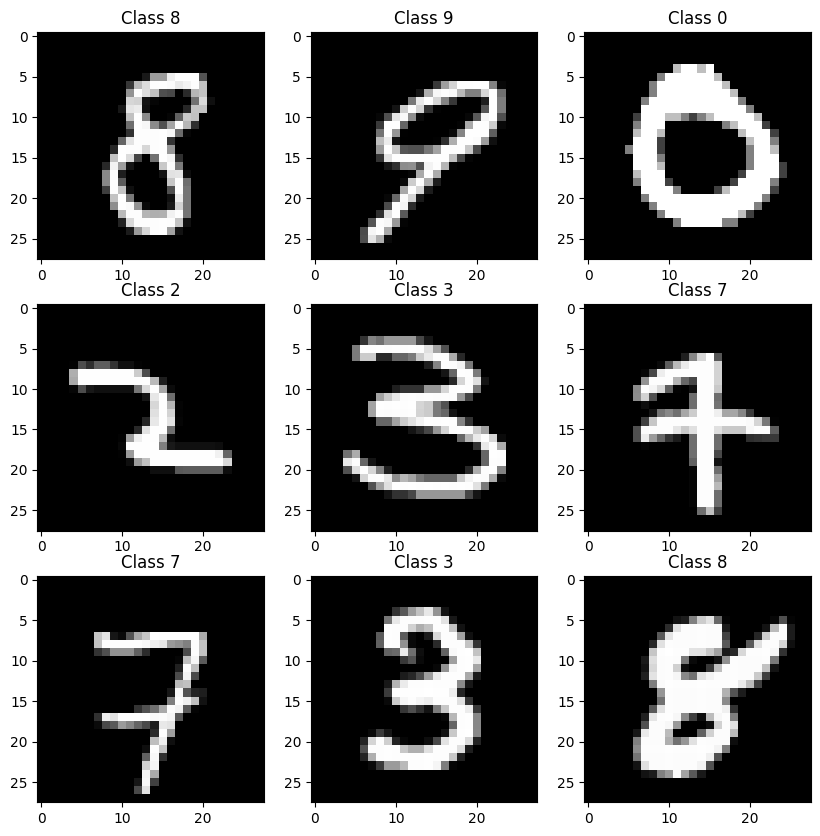

In [33]:
# Plot the images in a 3x3 grid
nrows = 3
ncols = 3
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i, 0, :, :], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels[i]))

# 3. Design the network.

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 32) # In keras it was called dense. Linear are fully connected Neural Network layers
        self.fc2 = nn.Linear(32, 10) # The first number must be the same as the output of the previous layer.

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
        
model = Net().to(device)

In [38]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
            Linear-2                   [-1, 10]             330
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [39]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Train the network.

In [40]:
def get_accuracy(y_pred, y_true):
    """Calculate the accuracy between predicted and true labels"""
    _, y_pred = torch.max(y_pred, dim=1)
    correct = torch.sum(y_pred == y_true).float()
    acc = correct / len(y_true)
    return acc

In [41]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs): # loop with the number of epochs
    for i, (images, labels) in enumerate(train_loader): # loop with batches of 64 images with all the training data

        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device) # I tell pyTorch to send the images and labels to the GPU
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 1.558 | Train accuracy: 0.918 | Valid loss: 1.550 | Valid accuracy: 0.923
Epoch 2/10 | Train loss: 1.539 | Train accuracy: 0.932 | Valid loss: 1.533 | Valid accuracy: 0.937
Epoch 3/10 | Train loss: 1.528 | Train accuracy: 0.940 | Valid loss: 1.525 | Valid accuracy: 0.943
Epoch 4/10 | Train loss: 1.520 | Train accuracy: 0.948 | Valid loss: 1.518 | Valid accuracy: 0.949
Epoch 5/10 | Train loss: 1.514 | Train accuracy: 0.952 | Valid loss: 1.512 | Valid accuracy: 0.956
Epoch 6/10 | Train loss: 1.510 | Train accuracy: 0.956 | Valid loss: 1.509 | Valid accuracy: 0.957
Epoch 7/10 | Train loss: 1.509 | Train accuracy: 0.958 | Valid loss: 1.508 | Valid accuracy: 0.957
Epoch 8/10 | Train loss: 1.504 | Train accuracy: 0.962 | Valid loss: 1.504 | Valid accuracy: 0.959
Epoch 9/10 | Train loss: 1.501 | Train accuracy: 0.965 | Valid loss: 1.502 | Valid accuracy: 0.962
Epoch 10/10 | Train loss: 1.501 | Train accuracy: 0.964 | Valid loss: 1.502 | Valid accuracy: 0.963


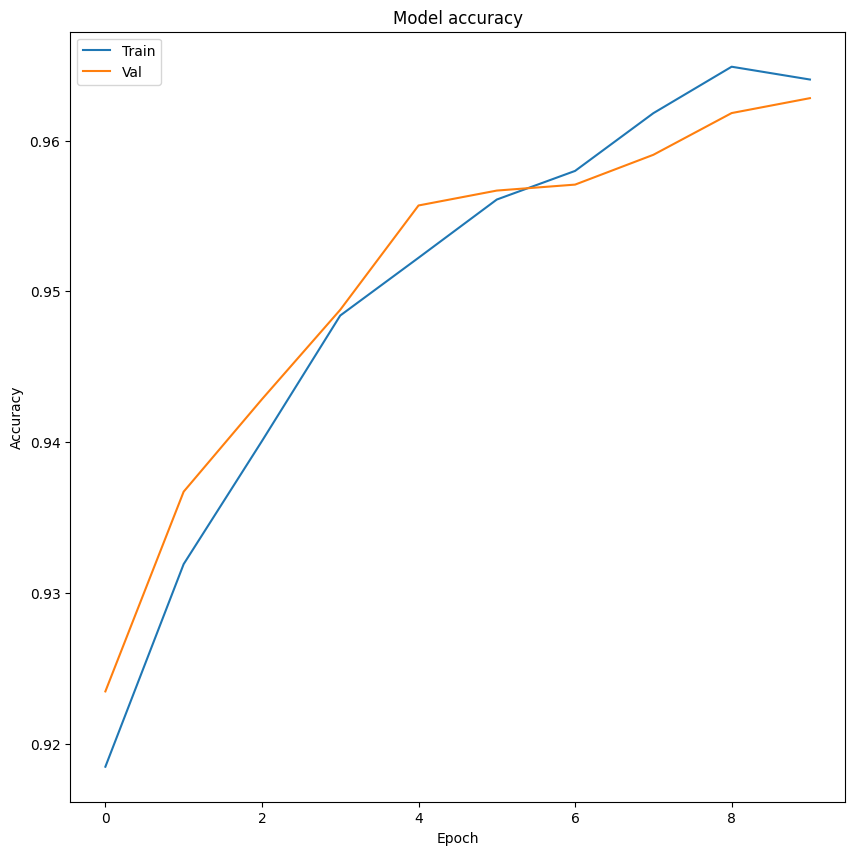

In [42]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

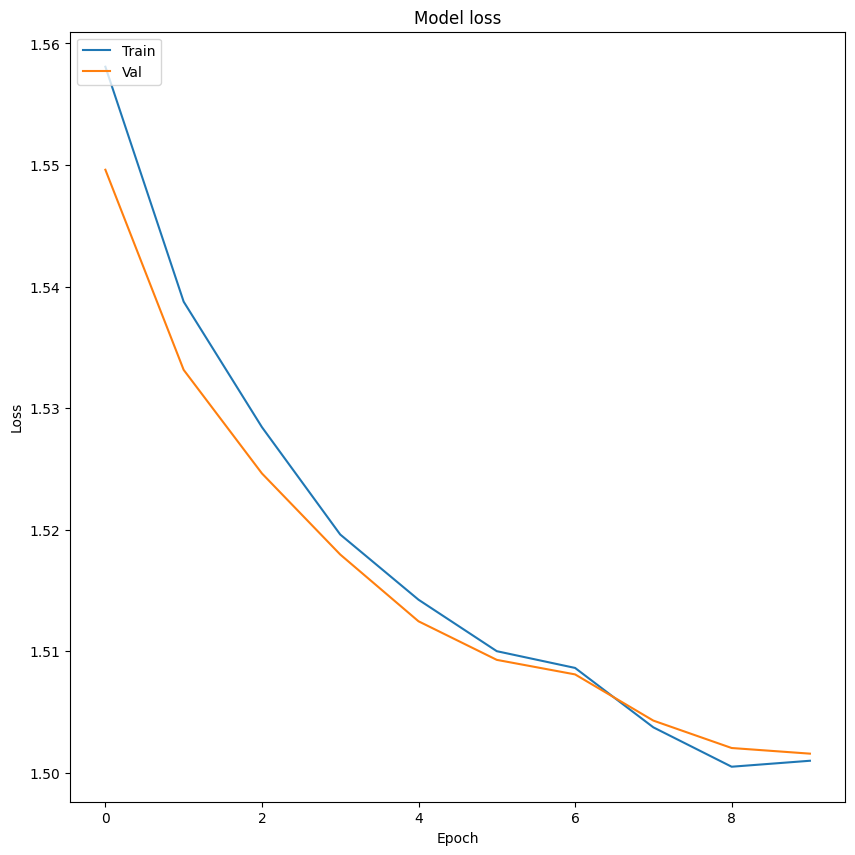

In [43]:
# Plot training and validation accuracy
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 5. Evaluate the model.

In [44]:
# Calculate metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.5142, device='cuda:0', grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9490, device='cuda:0')


# Exercise 1: Create a new model with 512 neurons in the hidden layer and repeat the process

In [45]:
# Design the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512) # In keras it was called dense. Linear are fully connected Neural Network layers
        self.fc2 = nn.Linear(512, 10) # The first number must be the same as the output of the previous layer.

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
        
model = Net().to(device)

In [46]:
# Show summary of the model

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [47]:
# Define loss function and optimizer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [48]:
def get_accuracy(y_pred, y_true):
    """Calculate the accuracy between predicted and true labels"""
    _, y_pred = torch.max(y_pred, dim=1)
    correct = torch.sum(y_pred == y_true).float()
    acc = correct / len(y_true)
    return acc

In [49]:
# Train the model

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs): # loop with the number of epochs
    for i, (images, labels) in enumerate(train_loader): # loop with batches of 64 images with all the training data

        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device) # I tell pyTorch to send the images and labels to the GPU
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")


Epoch 1/10 | Train loss: 1.518 | Train accuracy: 0.949 | Valid loss: 1.514 | Valid accuracy: 0.951
Epoch 2/10 | Train loss: 1.500 | Train accuracy: 0.966 | Valid loss: 1.499 | Valid accuracy: 0.965
Epoch 3/10 | Train loss: 1.489 | Train accuracy: 0.975 | Valid loss: 1.491 | Valid accuracy: 0.973
Epoch 4/10 | Train loss: 1.485 | Train accuracy: 0.978 | Valid loss: 1.489 | Valid accuracy: 0.973
Epoch 5/10 | Train loss: 1.480 | Train accuracy: 0.983 | Valid loss: 1.483 | Valid accuracy: 0.979
Epoch 6/10 | Train loss: 1.480 | Train accuracy: 0.983 | Valid loss: 1.487 | Valid accuracy: 0.975
Epoch 7/10 | Train loss: 1.476 | Train accuracy: 0.987 | Valid loss: 1.484 | Valid accuracy: 0.978
Epoch 8/10 | Train loss: 1.473 | Train accuracy: 0.989 | Valid loss: 1.481 | Valid accuracy: 0.982
Epoch 9/10 | Train loss: 1.472 | Train accuracy: 0.990 | Valid loss: 1.479 | Valid accuracy: 0.983
Epoch 10/10 | Train loss: 1.470 | Train accuracy: 0.992 | Valid loss: 1.479 | Valid accuracy: 0.983


In [50]:
# Obtain metrics in the test partition

# Calculate metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))


Test loss: tensor(1.4830, device='cuda:0', grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9796, device='cuda:0')


# Exercise 2: Add a hidden layer with 512 neurons to the model of exercise 1 and repeat the process

In [51]:
# Design the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 32) # In keras it was called dense. Linear are fully connected Neural Network layers
        self.fc2 = nn.Linear(32, 512) # In keras it was called dense. Linear are fully connected Neural Network layers

        self.fc3 = nn.Linear(512, 10) # The first number must be the same as the output of the previous layer.

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
        
model = Net().to(device)

In [52]:
# Show summary of the model

# Show summary of the model

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
            Linear-2                  [-1, 512]          16,896
Total params: 42,016
Trainable params: 42,016
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [53]:
# Define loss function and optimizer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
def get_accuracy(y_pred, y_true):
    """Calculate the accuracy between predicted and true labels"""
    _, y_pred = torch.max(y_pred, dim=1)
    correct = torch.sum(y_pred == y_true).float()
    acc = correct / len(y_true)
    return acc

In [55]:
# Train the model

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs): # loop with the number of epochs
    for i, (images, labels) in enumerate(train_loader): # loop with batches of 64 images with all the training data

        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device) # I tell pyTorch to send the images and labels to the GPU
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")


Epoch 1/10 | Train loss: 5.429 | Train accuracy: 0.831 | Valid loss: 5.417 | Valid accuracy: 0.841
Epoch 2/10 | Train loss: 5.411 | Train accuracy: 0.841 | Valid loss: 5.400 | Valid accuracy: 0.851
Epoch 3/10 | Train loss: 5.403 | Train accuracy: 0.846 | Valid loss: 5.395 | Valid accuracy: 0.855
Epoch 4/10 | Train loss: 5.398 | Train accuracy: 0.851 | Valid loss: 5.391 | Valid accuracy: 0.858
Epoch 5/10 | Train loss: 5.394 | Train accuracy: 0.853 | Valid loss: 5.388 | Valid accuracy: 0.859
Epoch 6/10 | Train loss: 5.392 | Train accuracy: 0.855 | Valid loss: 5.387 | Valid accuracy: 0.859
Epoch 7/10 | Train loss: 5.390 | Train accuracy: 0.857 | Valid loss: 5.384 | Valid accuracy: 0.862
Epoch 8/10 | Train loss: 5.387 | Train accuracy: 0.860 | Valid loss: 5.383 | Valid accuracy: 0.862
Epoch 9/10 | Train loss: 5.306 | Train accuracy: 0.942 | Valid loss: 5.303 | Valid accuracy: 0.944
Epoch 10/10 | Train loss: 5.301 | Train accuracy: 0.946 | Valid loss: 5.301 | Valid accuracy: 0.946


In [57]:
# Obtain metrics in the test partition

# Calculate metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))


Test loss: tensor(5.3137, device='cuda:0', grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9335, device='cuda:0')


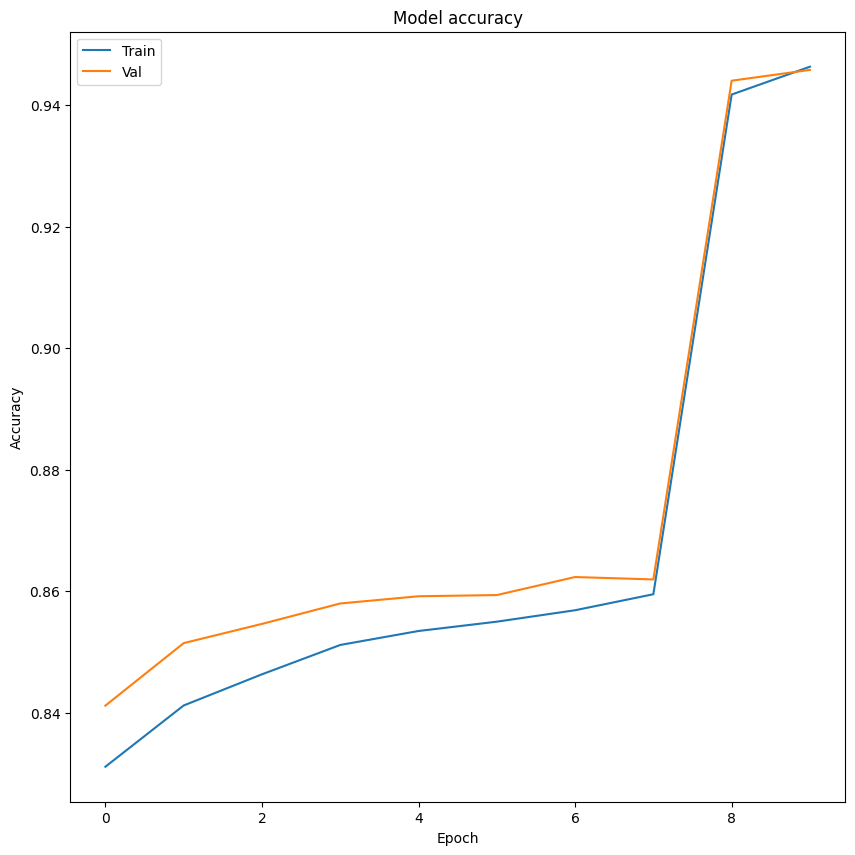

In [56]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

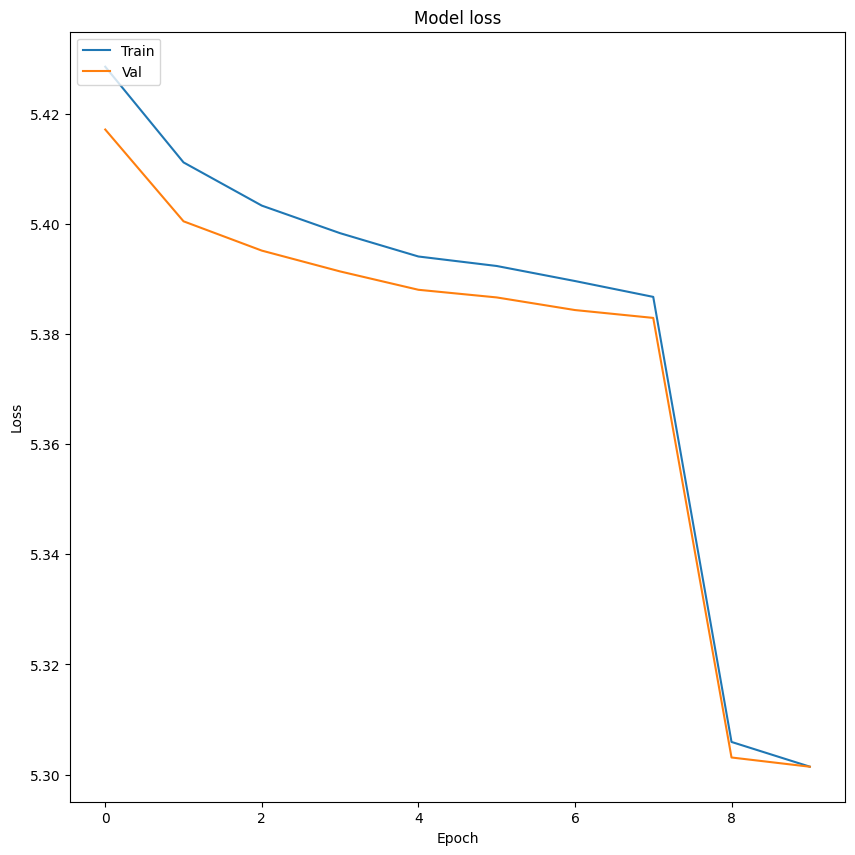

In [58]:
# Plot training and validation accuracy
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()